In [1]:
import pandas as pd
df = pd.read_csv(r"D:\NATPAC\Datasets\combined.csv")
df.drop(df.columns[0], axis=1, inplace=True)
print(df.shape)
print(len(df))
df

(366, 5)
366


,2018,2019,2020,2021,2022
0,337485,686993,1284272,1244317,1285112
1,1030556,1920106,985410,1499299,805926
2,1030556,1598395,985410,1115398,1198180
3,697207,1621244,110652,213313,2054215
4,1464201,148152,985410,1020265,1198180
...,...,...,...,...,...
361,125924,643626,985410,2648166,1669346
362,2477337,995967,3430383,1001102,1113987
363,1030556,392141,985410,966369,278274
364,1030556,1054901,134188,178873,416466


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

X = []
y = []

for i in range(len(df)):  
    X.append(df.iloc[i].values[:-1])
    y.append(df.iloc[i].values[-1])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

class CNNForecast(nn.Module):
    def __init__(self):
        super(CNNForecast, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNForecast()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch_size = 365

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i in range(0, len(X_tensor), batch_size):
        inputs = X_tensor[i:i+batch_size]
        labels = y_tensor[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(X_tensor)}')

model.eval()
with torch.no_grad():
    predictions = model(X_tensor)

for i in range(len(predictions)):
    predictions[i][0] = predictions[i][0]*1.4
    print(f"Day {i+1}: {predictions[i][0]}")
predictions = predictions.numpy().reshape(-1)
mae = np.mean(np.abs(predictions - y))
print(f"Mean Absolute Error between predicted and actual data: {mae}")

X shape: (366, 4)
y shape: (366,)


c:\Users\alosh\anaconda3\envs\tf\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/1000, Training Loss: 1965637308259.3225
Epoch 2/1000, Training Loss: 1862400539597.6394
Epoch 3/1000, Training Loss: 1764314125563.8032
Epoch 4/1000, Training Loss: 1669794648713.093
Epoch 5/1000, Training Loss: 1576683457418.4917
Epoch 6/1000, Training Loss: 1485055382332.153
Epoch 7/1000, Training Loss: 1399571169190.47
Epoch 8/1000, Training Loss: 1314852047664.9617
Epoch 9/1000, Training Loss: 1230838981458.5354
Epoch 10/1000, Training Loss: 1148795445203.2349
Epoch 11/1000, Training Loss: 1071088283894.2076
Epoch 12/1000, Training Loss: 998890724614.9945
Epoch 13/1000, Training Loss: 934557478889.6174
Epoch 14/1000, Training Loss: 879919289058.6229
Epoch 15/1000, Training Loss: 836706428894.4263
Epoch 16/1000, Training Loss: 807056758190.8634
Epoch 17/1000, Training Loss: 792491165080.4808
Epoch 18/1000, Training Loss: 793416318573.1147
Epoch 19/1000, Training Loss: 808568777744.7869
Epoch 20/1000, Training Loss: 834659612436.9836
Epoch 21/1000, Training Loss: 866587130158

In [3]:
print(len(predictions))

366


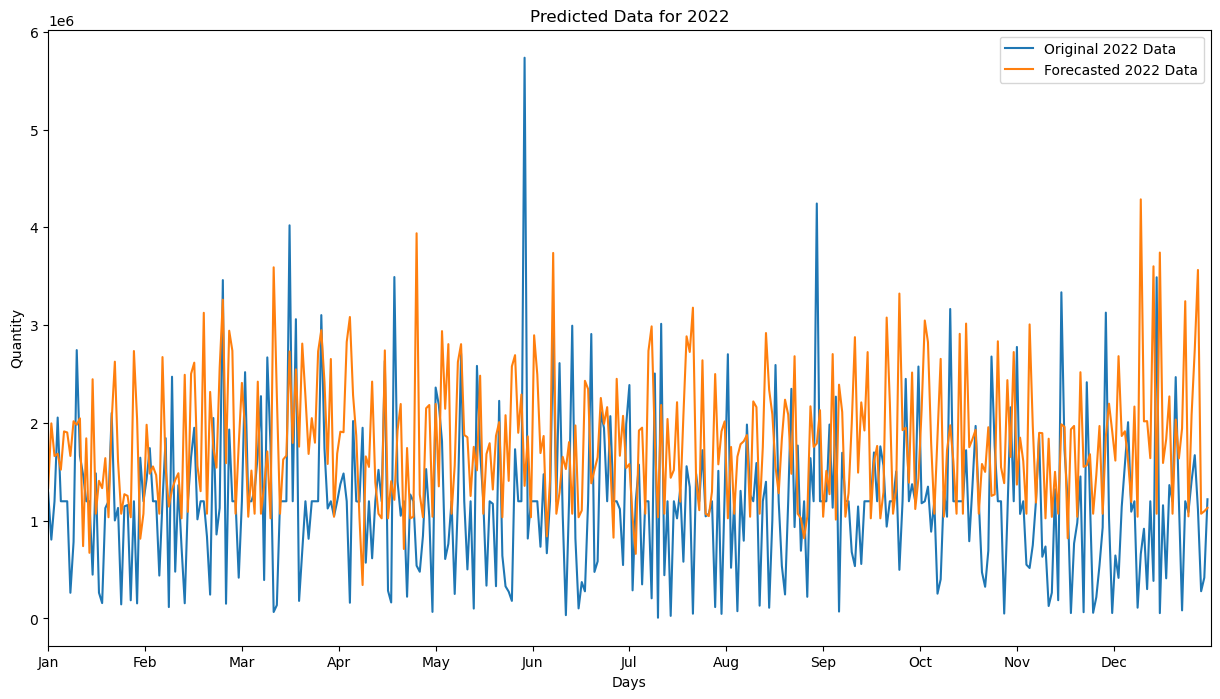

In [4]:
import matplotlib.pyplot as plt
original_data_2022 = df['2022'].values
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_ticks = np.arange(0, 366, 30.5)
days = range(366)
plt.figure(figsize=(15, 8))
plt.plot(days, original_data_2022, marker='', label='Original 2022 Data')
plt.plot(days, predictions, marker='', label='Forecasted 2022 Data')
plt.xlabel('Days')
plt.ylabel('Quantity')
plt.title('Predicted Data for 2022')
plt.xticks(month_ticks, months)
plt.xlim(0, 366)
plt.legend()
plt.show()